## Assignment for Recommendation Systems
<b>Name: Preneeth O <br>
Batch: 11</b>

## Introduction ##

Build a recommendation system to recommend products to customers based on the their previous ratings for other products.


Dataset: <a https://olympus.greatlearning.in/courses/6628/files/359268/download?verifier=Z5A0IUiGXfBHy85UuNvwkLGoUejdqi6k5gKQPQJ3&wrap=1>ratings_Electronics.csv</a>

### 1. Import all the necessary libraries

In [1]:
#!pip install surprise

In [2]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split

#import statsmodels.api as sm
from sklearn import metrics
from sklearn import datasets
import seaborn as sn

%matplotlib inline
sn.set(color_codes = True)

### 2. Load the Data & Perform basic EDA

In [3]:
dataSet = pd.read_csv('ratings_Electronics.csv')
dataSet.columns = ['UserId', 'ProductId', 'Rating', 'Timestamp']
dataSet.head()

,UserId,ProductId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [4]:
dataSet.shape

(7824481, 4)

There are 7 Million records with 4 columns

In [5]:
# Check the datatypes.
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
UserId       object
ProductId    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [6]:
dataSet.head(5)

,UserId,ProductId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


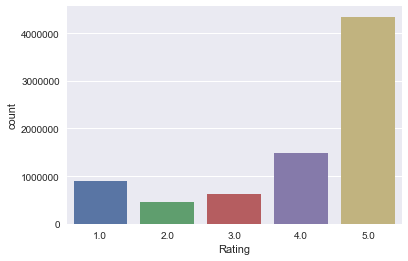

In [7]:
sn.countplot(dataSet.Rating)

In [8]:
# Average Rating of each product.
dataSet.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head()

ProductId
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: Rating, dtype: float64

The products have now been sorted according to the ascending order of their ratings. However, there is a problem. A product can make it to the top of the above list even if only a single user has given it five stars. Therefore, the above stats can be misleading. Normally, a product which is really a good one gets a higher rating by a large number of users.

In [9]:
# Count of Rating for each product.
dataSet.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head()

ProductId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

There are products with lot of ratings. Top rated products will normaly have lot of ratings. Now we know that both the average rating per product and the number of ratings per product are important attributes. Let's create a new dataframe that contains both of these attributes.

In [10]:
ratings_mean_count = pd.DataFrame(dataSet.groupby('ProductId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(dataSet.groupby('ProductId')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
ProductId,,
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1


You can see product, along with the average rating and number of ratings for the product.

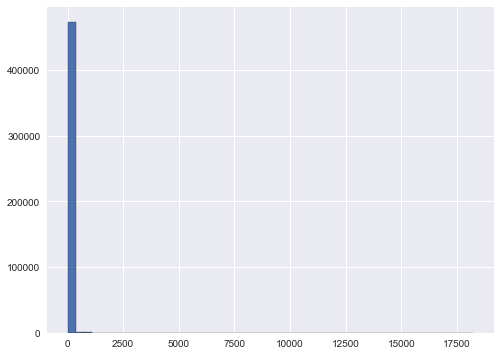

In [11]:
#Plot a histogram for the number of ratings represented by the "rating_counts" column in the above dataframe.

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

In [12]:
print ("Ratings count less than 25 is {} ".format(ratings_mean_count[ratings_mean_count['rating_counts'] < 25].shape[0]))
print ("Ratings count greater than equal to 25 is {} ".format(ratings_mean_count[ratings_mean_count['rating_counts'] >= 25].shape[0]))
print ("Ratings count less than 100 is {} ".format(ratings_mean_count[ratings_mean_count['rating_counts'] > 100].shape[0]))

Ratings count less than 25 is 427827 
Ratings count greater than equal to 25 is 48174 
Ratings count less than 100 is 13077 


<b>Findings</b>

* Most of the products have received less than 25 ratings. While the number of movies having more than 100 ratings is very low.

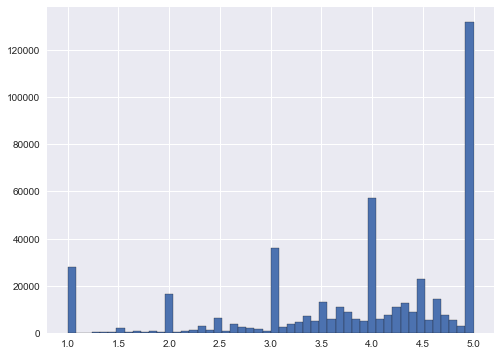

In [13]:
#Plot a histogram for the mean ratings represented by the "Rating" column in the above dataframe.

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<b>Findings</b>

* There are large number of movies with 4 & 5 ratings.
* We need to see if the number of ratings for high ratings is also high.

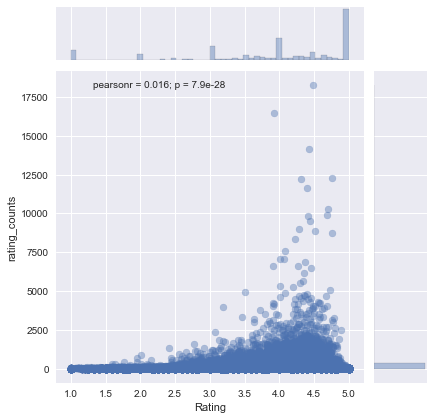

In [14]:
# Plot average ratings against the number of ratings:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sn.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<b>Findings</b>

* From this we can conclude that products with high average rating will have more number of user ratings.

### 3. Clean up data; Prepare data for Modeling

In [15]:
counts=dataSet.UserId.value_counts()
counts.sort_values(ascending=True).head()

A33ZV3RF86H0WN    1
A1HXFF5AZIK5JK    1
A2Y3EOB732NXZN    1
A3ELXP44GY9U32    1
A3DDHPRC672YGT    1
Name: UserId, dtype: int64

<b>Findings</b>

There a lot of users who have provided very few ratings. Considering the entries from these users may not contribute much to the recommendation system we want to build, we may drop all users who have rated less than 50 times

In [16]:
dataSet_filtered=dataSet[dataSet['UserId'].isin(counts[counts >= 50].index)]
dataSet_filtered.shape

(125871, 4)

<b>Findings</b>

Total records have been reduced from 7824481 to 125871, by eliminating all users who have rated less than 50 times

### 4.  Build Popularity Recommender model

* Create a DataFrame grouped based on Product and Ratings. Based on the number of user ratings, Rank the data
* Get 5 Top 5 ranked Products from the list
* Show the same list for all users.

### 4.1 Find the Top Rated Products

In [17]:
filteredDataSet_grouped = dataSet_filtered.groupby(['ProductId','Rating']).agg({'UserId': 'count'}).reset_index()
filteredDataSet_grouped.rename(columns = {'UserId': '#Users'},inplace=True)
#train_data_grouped['score'] = train_data_grouped['Rating'] * train_data_grouped['#Users']
filteredDataSet_grouped.head()

,ProductId,Rating,#Users
0,0594451647,5.0,1
1,0594481813,3.0,1
2,0970407998,1.0,1
3,0970407998,4.0,1
4,0972683275,4.0,1


In [18]:
#Sort the data 
filteredDataSet_sort = filteredDataSet_grouped.sort_values(['#Users', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon number of users 
filteredDataSet_sort['Rank'] = filteredDataSet_sort['#Users'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = filteredDataSet_sort.head(5) 
popularity_recommendations 

,ProductId,Rating,#Users,Rank
33926,B003ES5ZUU,5.0,165,1.0
53202,B007WTAJTO,5.0,135,2.0
14564,B000N99BBC,5.0,134,3.0
54261,B0088CJT4U,5.0,91,4.0
53733,B00829TIEK,5.0,87,5.0


### 4.2 List the Top 5 Recommended Products for selected Users

In [19]:
# Use popularity based recommender model to make predictions
def recommend(user_id):  
    '''Return the recommendation for given user id
    Args:
        user_id(String): User id for which recommendation to be identified
        
    Returns:
    A DataFrame with product list containing - userID   ProductId  Rating  #Users  Rank
    '''
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [20]:
def getPopularityReco(find_recom):
    '''Prints the recommended products for given users list
    Args:
        find_recom(List): User ids for which recommendation to be printed
        
    Returns:
    None
    '''
    for i in find_recom:
        print("Here is the recommendation for the userId: {}\n".format(i))
        print(recommend(i))    
        print("\n") 
        


In [21]:
find_recom = ['A1PVX61PRPVX27','A17RFKCYS69M3Y','A1EXGL6L0QQ0M5']   # This list is user choice.
getPopularityReco(find_recom)

Here is the recommendation for the userId: A1PVX61PRPVX27

               userID   ProductId  Rating  #Users  Rank
33926  A1PVX61PRPVX27  B003ES5ZUU     5.0     165   1.0
53202  A1PVX61PRPVX27  B007WTAJTO     5.0     135   2.0
14564  A1PVX61PRPVX27  B000N99BBC     5.0     134   3.0
54261  A1PVX61PRPVX27  B0088CJT4U     5.0      91   4.0
53733  A1PVX61PRPVX27  B00829TIEK     5.0      87   5.0


Here is the recommendation for the userId: A17RFKCYS69M3Y

               userID   ProductId  Rating  #Users  Rank
33926  A17RFKCYS69M3Y  B003ES5ZUU     5.0     165   1.0
53202  A17RFKCYS69M3Y  B007WTAJTO     5.0     135   2.0
14564  A17RFKCYS69M3Y  B000N99BBC     5.0     134   3.0
54261  A17RFKCYS69M3Y  B0088CJT4U     5.0      91   4.0
53733  A17RFKCYS69M3Y  B00829TIEK     5.0      87   5.0


Here is the recommendation for the userId: A1EXGL6L0QQ0M5

               userID   ProductId  Rating  #Users  Rank
33926  A1EXGL6L0QQ0M5  B003ES5ZUU     5.0     165   1.0
53202  A1EXGL6L0QQ0M5  B007WTAJTO  

/Users/preneeth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


<b>Findings:</b>
* From the above popularity recommendation model, we can see top 5 recommenations is provided for each user
* The recommandation is same for all users.
* It is a drawback of popularity recommendation model, it does not personalize recommendations to user specific.

### 5.  Build Collaborative Filtering model.

* Create various models and list the performance of the model based on RMSE
* Pick the best model and get the recommendations for each user.

### 5.1 Create Models and check Performance

In [22]:

reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, product id and ratings (in that order).
data = Dataset.load_from_df(dataSet_filtered[['UserId', 'ProductId', 'Rating']], reader)


In [23]:
from surprise.model_selection import cross_validate
from surprise import SVD, SlopeOne, NMF, CoClustering, NormalPredictor, KNNBaseline, KNNBasic, KNNWithZScore, KNNWithMeans, BaselineOnly

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:    # Perform cross validation
#for algorithm in [SVD(), NMF()]:
 
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print(algorithm)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,fit_time,test_rmse,test_time
Algorithm,,,
BaselineOnly,0.397752,0.983066,0.240625
SVD,5.964049,0.986841,0.451717
KNNBaseline,0.548640,1.045284,1.078366
KNNWithMeans,0.207791,1.067574,0.856064
KNNWithZScore,0.283273,1.067681,1.055564
KNNBasic,0.166136,1.113985,0.910249
NormalPredictor,0.159627,1.366504,0.451553


<b>Findings:</b>
* From above we see that <b>BaselineOnly is the top performing model with least RMSE</b>. 
* Next run the BaselineOnly model to get recommendation for identified set of users.

### 5.2 Select the Best performing Model

* BaselineOnly is the short listed model
* Get Recommendations for each user by running through BaselineOnly model

In [24]:
trainset, testset = train_test_split(data, test_size=0.25)
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.9821


0.9820697605659485

In [32]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 5.
    Returns:
    A dict where keys are userids and values are lists of tuples:
        [(Product Id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, round(est,2)))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [33]:
top_n = get_top_n(predictions, n=5)
userId_check = str('A1PVX61PRPVX27')
print ("Recommendation for user id {} is \n\n{}".format(userId_check, top_n.get(userId_check)))

Recommendation for user id A1PVX61PRPVX27 is 

[('B00A35WYBA', 5), ('B00B4GGW5Q', 5), ('B007WTAJTO', 5), ('B0014XDBIA', 4.8), ('B00009RA60', 4.74)]


<b>Findings:</b>
* User Id - A1PVX61PRPVX27gets personalized product recommendations, unlike popularity model which returns same recommendations for all users 
* Next run the BaselineOnly model to get recommendation for identified set of users.

### 5.3 List the Top 5 Recommended Products for selected Users

In [34]:
find_recom = ['A1PVX61PRPVX27','A17RFKCYS69M3Y','A1EXGL6L0QQ0M5']  # This list is user choice.

def getColabrativeReco(find_recom):
    '''Prints the recommended products for given users list
    Args:
        find_recom(List): User ids for which recommendation to be printed
        
    Returns:
    None
    '''
    for i in find_recom:
        print("\nHere is the recommendation for the userId: {}\n".format(i))
        dfRec = pd.DataFrame(top_n.get((i)))
        dfRec.columns = ['ProductId', 'Estimated Rating']
        print(dfRec)


getColabrativeReco(find_recom)


Here is the recommendation for the userId: A1PVX61PRPVX27

    ProductId  Estimated Rating
0  B00A35WYBA              5.00
1  B00B4GGW5Q              5.00
2  B007WTAJTO              5.00
3  B0014XDBIA              4.80
4  B00009RA60              4.74

Here is the recommendation for the userId: A17RFKCYS69M3Y

    ProductId  Estimated Rating
0  B000BTL0OA              3.14
1  B005CLMJLU              2.95
2  B00005T3DP              2.89
3  B0002JKGRQ              2.84
4  B000FCN9UG              2.74

Here is the recommendation for the userId: A1EXGL6L0QQ0M5

    ProductId  Estimated Rating
0  B008EQZ25K              4.88
1  B004Y1AYAC              4.75
2  B00429N18S              4.71
3  B003Z4G3I6              4.69
4  B005HQ50SO              4.64


### 6. Conclusion 

We have built 2 approaches <b>1) Popularity Recommender model 2) Collaborative Filtering model </b> and run both of them for same set of 3 users and below are findings based on the results

* Popularity Recommender model - It recommended Top 5 Products but the <b>recommendations are same for all users</b>.
* Collaborative Filtering model - It Top 5 <b>personalized recommendation for each user</b> based on their ratings given for other products and simalar user's ratings.

So we can conclude that <b>Collaborative Filtering model is better </b> as it give a personalized recommendations to the users.